In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import pmdarima as pm
import scipy.stats as stats
from sklearn.svm import SVR
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [2]:
# Load the dataset
df = pd.read_csv("rainfall.csv")

# Convert datetime string to Python datetime object and set as the index
df["datetime"] = pd.to_datetime(df["datetime"], format="%d-%m-%Y")
df.set_index("datetime", inplace=True)

# df = np.log10(df)

# columns to drop
columns_to_drop = ["windspeed", "precipprob", "preciptype"]
df = df.drop(columns=columns_to_drop)

# standardise
#scaler = StandardScaler()
#df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)


# Select a specific date range
start_date = "2011-10-01"
end_date = "2025-12-31"
df = df[(df.index >= start_date) & (df.index <= end_date)]
df

,temp,dew,humidity,sealevelpressure,winddir,solarradiation
datetime,,,,,,
2016-01-01,28.4,11.9,37.8,1016.4,147.5,216.1
2016-01-02,26.8,13.0,44.8,1017.2,110.3,215.7
2016-01-03,25.5,14.6,52.8,1015.7,145.3,221.1
2016-01-04,26.4,13.1,46.6,1015.3,126.9,216.2
2016-01-05,27.1,13.5,44.9,1014.4,125.5,208.1
...,...,...,...,...,...,...
2020-11-11,27.4,12.2,41.5,1011.8,108.3,220.4
2020-11-12,28.0,13.0,40.9,1012.6,148.4,225.1
2020-11-13,28.4,18.7,56.9,1011.9,131.8,223.4


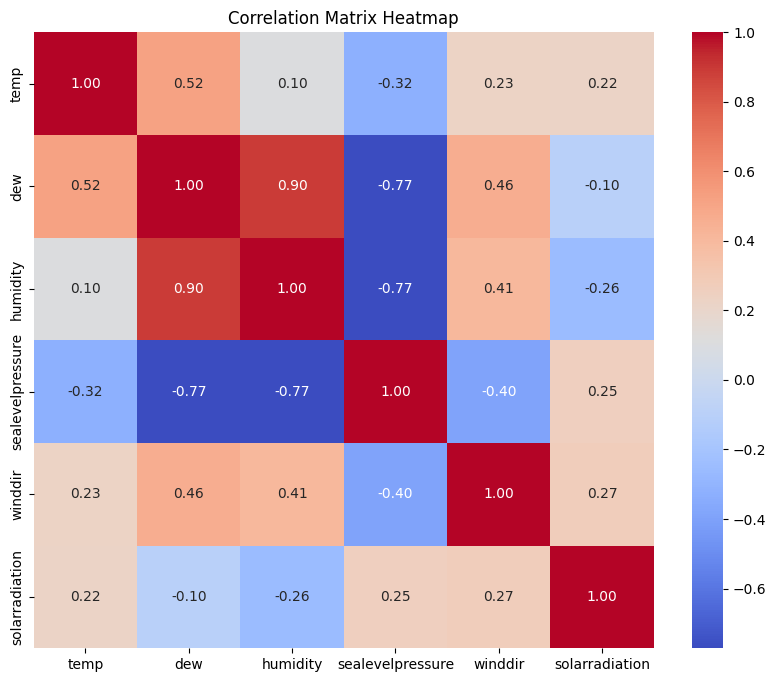

In [3]:
# Create a heatmap to visualize the correlation matrix using Plotly
correlation_matrix = df.corr()
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()
# Create subplots for whole data visualisation
plot_rows = 6
plot_cols = 1
fig = make_subplots(rows=plot_rows, cols=plot_cols)

# Add traces to the subplots
x = 0
for i in range(1, plot_rows + 1):
    for j in range(1, plot_cols + 1):
        fig.add_trace(
            go.Scatter(
                x=df.index, y=df[df.columns[x]].values, name=df.columns[x], mode="lines"
            ),
            row=i,
            col=j,
        )
        x += 1

# Format and display the figure
fig.update_layout(height=1200, width=1200,title_text="Daily Data")
fig.show()

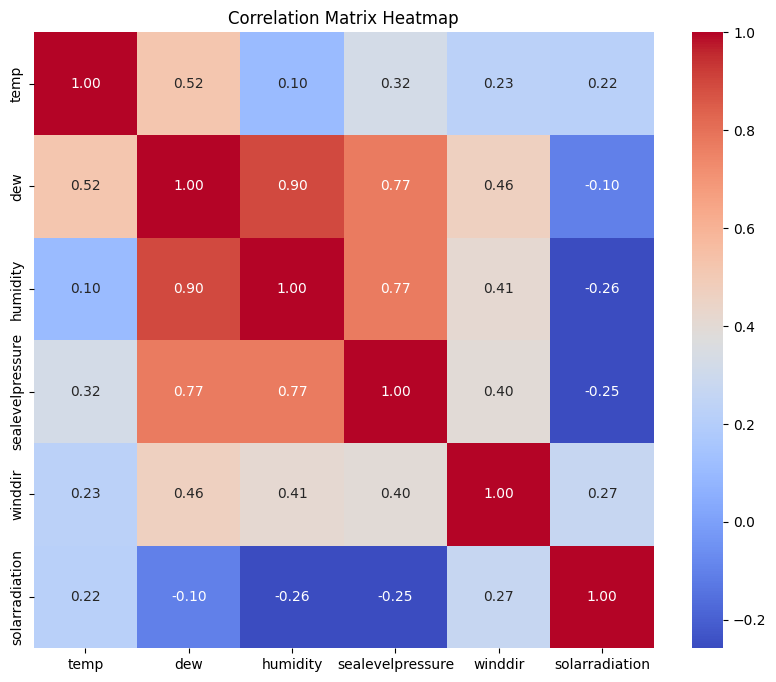

In [4]:
# Invert a specific column (e.g., column 'C')
column_to_invert = 'sealevelpressure'
df[column_to_invert] = df[column_to_invert] * -1
correlation_matrix = df.corr()
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()
# Create subplots for whole data visualisation
plot_rows = 6
plot_cols = 1
fig = make_subplots(rows=plot_rows, cols=plot_cols)

# Add traces to the subplots
x = 0
for i in range(1, plot_rows + 1):
    for j in range(1, plot_cols + 1):
        fig.add_trace(
            go.Scatter(
                x=df.index, y=df[df.columns[x]].values, name=df.columns[x], mode="lines"
            ),
            row=i,
            col=j,
        )
        x += 1

# Format and display the figure
fig.update_layout(height=1200, width=1200,title_text="Daily Data")
fig.show()

In [5]:
# Perform a 70-30 train-test split
train_percentage = 0.7
train, test = train_test_split(
    df, train_size=train_percentage, test_size=1 - train_percentage, shuffle=False
)

In [6]:
# Define the target columns and seasonal interval (m)
target_column = "dew"
train_columns = ["dew", "humidity", "sealevelpressure"]
colmn_idx = 0


# Check for seasonality using pmdarima
for train_column in train_columns:
    seasonal_test_result = pm.arima.ndiffs(train[train_column], test="adf")
    print(train_column)
    if seasonal_test_result > 0:
        print("Data is seasonal.")
        # diff the data to make it seasonal
        # train[train_column] = train[train_column].diff().fillna(0)
    else:
        print("Data is not seasonal.")
    print("_____________________________________________")

dew
Data is seasonal.
_____________________________________________
humidity
Data is not seasonal.
_____________________________________________
sealevelpressure
Data is seasonal.
_____________________________________________


In [7]:
# Create a VAR model
model = VAR(train[train_columns])

# Fit the VAR model
model_fitted = model.fit(122)

c:\Users\navee\Projects\jupyter\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



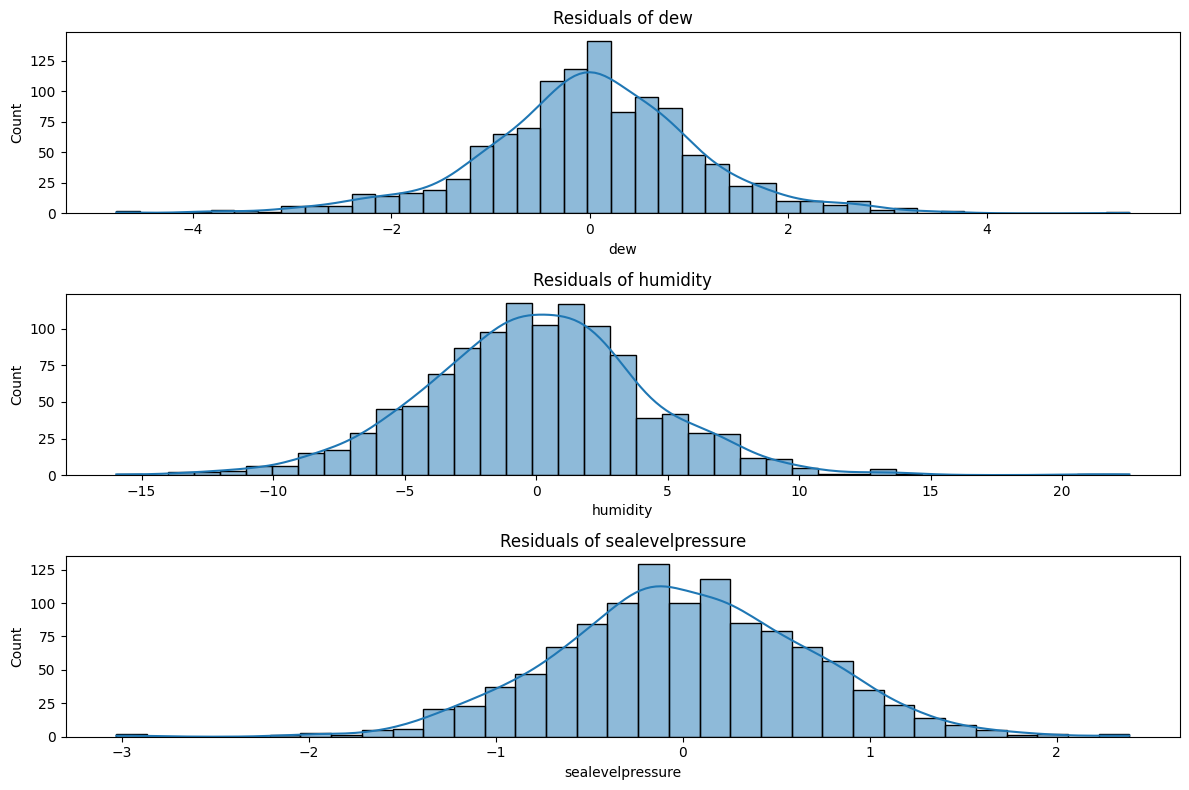

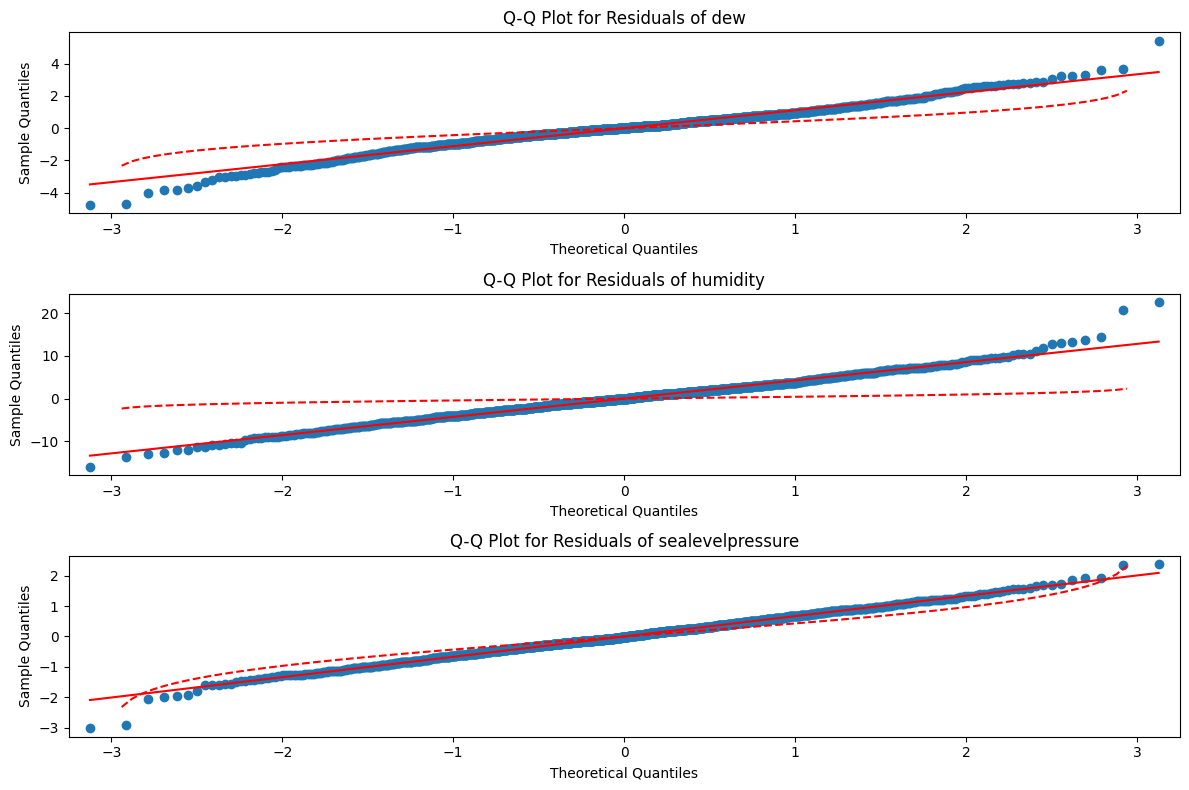

In [8]:
# Residual analysis
residuals = model_fitted.resid

# Plot the residuals
fig, axes = plt.subplots(nrows=residuals.shape[1], figsize=(12, 8))
for i, ax in enumerate(axes):
    sns.histplot(residuals.iloc[:, i], kde=True, ax=ax)
    ax.set_title(f"Residuals of {residuals.columns[i]}")
plt.tight_layout()
plt.show()

# Create Q-Q plots for each variable's residuals
fig, axes = plt.subplots(nrows=residuals.shape[1], figsize=(12, 8))
for i, ax in enumerate(axes):
    sm.qqplot(residuals.iloc[:, i], line="s", ax=ax)
    ax.set_title(f"Q-Q Plot for Residuals of {residuals.columns[i]}")
    # Add a line to represent the theoretical normal distribution
    x = np.linspace(-3, 3, 100)
    y = stats.norm.ppf((x + 3) / 6)
    ax.plot(x, y, color="red", linestyle="--")
plt.tight_layout()
plt.show()

In [9]:
# Forecast using the VAR model
forecast = model_fitted.forecast(y=train[train_columns].values, steps=len(test))

# Create line charts for forecasted and observed values
fig_temp = go.Figure()

observed_temp = test[target_column]
forecast_temp = forecast[:, colmn_idx ]  # Access the forecasted temperature column
# Add traces for observed values and forecast
fig_temp.add_trace(go.Scatter(x=test.index, y=observed_temp, mode='lines', name='Observed temp'))
fig_temp.add_trace(go.Scatter(x=test.index, y=forecast_temp, mode='lines', name='Forecasted temp'))

# Customize the layout for the plot
fig_temp.update_layout(
    title=f"Forecast vs. Observed {train_columns[colmn_idx]}",
    xaxis_title="Date",
    yaxis_title=train_columns[colmn_idx],
)

# Show the plot
fig_temp.show()

In [10]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test[target_column], forecast_temp))

# Calculate MAE
mae = mean_absolute_error(test[target_column], forecast_temp)


# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(test[target_column], forecast_temp)


# Calculate sMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 200 * np.mean(np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))


smape = symmetric_mean_absolute_percentage_error(test[target_column], forecast_temp)

# Calculate R-squared (R²) score
r_squared = r2_score(test[target_column], forecast_temp)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Symmetric Mean Absolute Percentage Error (sMAPE):", smape)
print("R-squared (R²) Score:", r_squared)

Root Mean Squared Error (RMSE): 2.240545614826025
Mean Absolute Error (MAE): 1.8511587755264638
Mean Absolute Percentage Error (MAPE): 8.807132689133265
Symmetric Mean Absolute Percentage Error (sMAPE): 8.776306687910825
R-squared (R²) Score: 0.6544591436012337


In [11]:
""" r_max_val = 0
for i in range(1, 255):
    model_fitted = model.fit(i)
    # Forecast using the VAR model
    forecast = model_fitted.forecast(y=train[train_columns].values, steps=len(test))

    observed_temp = test[target_column]
    forecast_temp = forecast[:, colmn_idx]  # Access the forecasted temperature column
    r_squared = r2_score(test[target_column], forecast_temp)
    if r_squared > r_max_val:
        r_max_val = r_squared
        print(r_max_val)
        print(i) """

' r_max_val = 0\nfor i in range(1, 255):\n    model_fitted = model.fit(i)\n    # Forecast using the VAR model\n    forecast = model_fitted.forecast(y=train[train_columns].values, steps=len(test))\n\n    observed_temp = test[target_column]\n    forecast_temp = forecast[:, colmn_idx]  # Access the forecasted temperature column\n    r_squared = r2_score(test[target_column], forecast_temp)\n    if r_squared > r_max_val:\n        r_max_val = r_squared\n        print(r_max_val)\n        print(i) '